<a href="https://colab.research.google.com/github/kopalgarg/kaggle-competitions/blob/main/heart-disease-UCI-explainability/explainability_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, auc
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
import shap
from pdpbox import pdp, info_plots

Read in the Heart Disease dataset directly from GitHub

In [20]:
url = 'https://raw.githubusercontent.com/kopalgarg/kaggle-competitions/main/heart-disease-UCI-explainability/data_files/heart.csv?token=AE44Q6U4Q5DZB46T2CTOCIDA4YBSM'
df = pd.read_csv(url)
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Test-train split (90-10)

In [21]:
x = df.drop('target', axis=1)
y = df.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .1, random_state = 10)

Train the model

In [22]:
model = RandomForestClassifier(max_depth = 5)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
estimator = model.estimators_[1]

cols = [i for i in x_train.columns]
y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'No HD'
y_train_str[y_train_str == '1'] = 'HD'
y_train_str = y_train_str.values

Visualize the RF model

In [39]:
export_graphviz(estimator, out_file = 'tree.dot', feature_names= cols, class_names = y_train_str,
                rounded = True, proportion = True, label = 'root', precision = 2, filled = True)

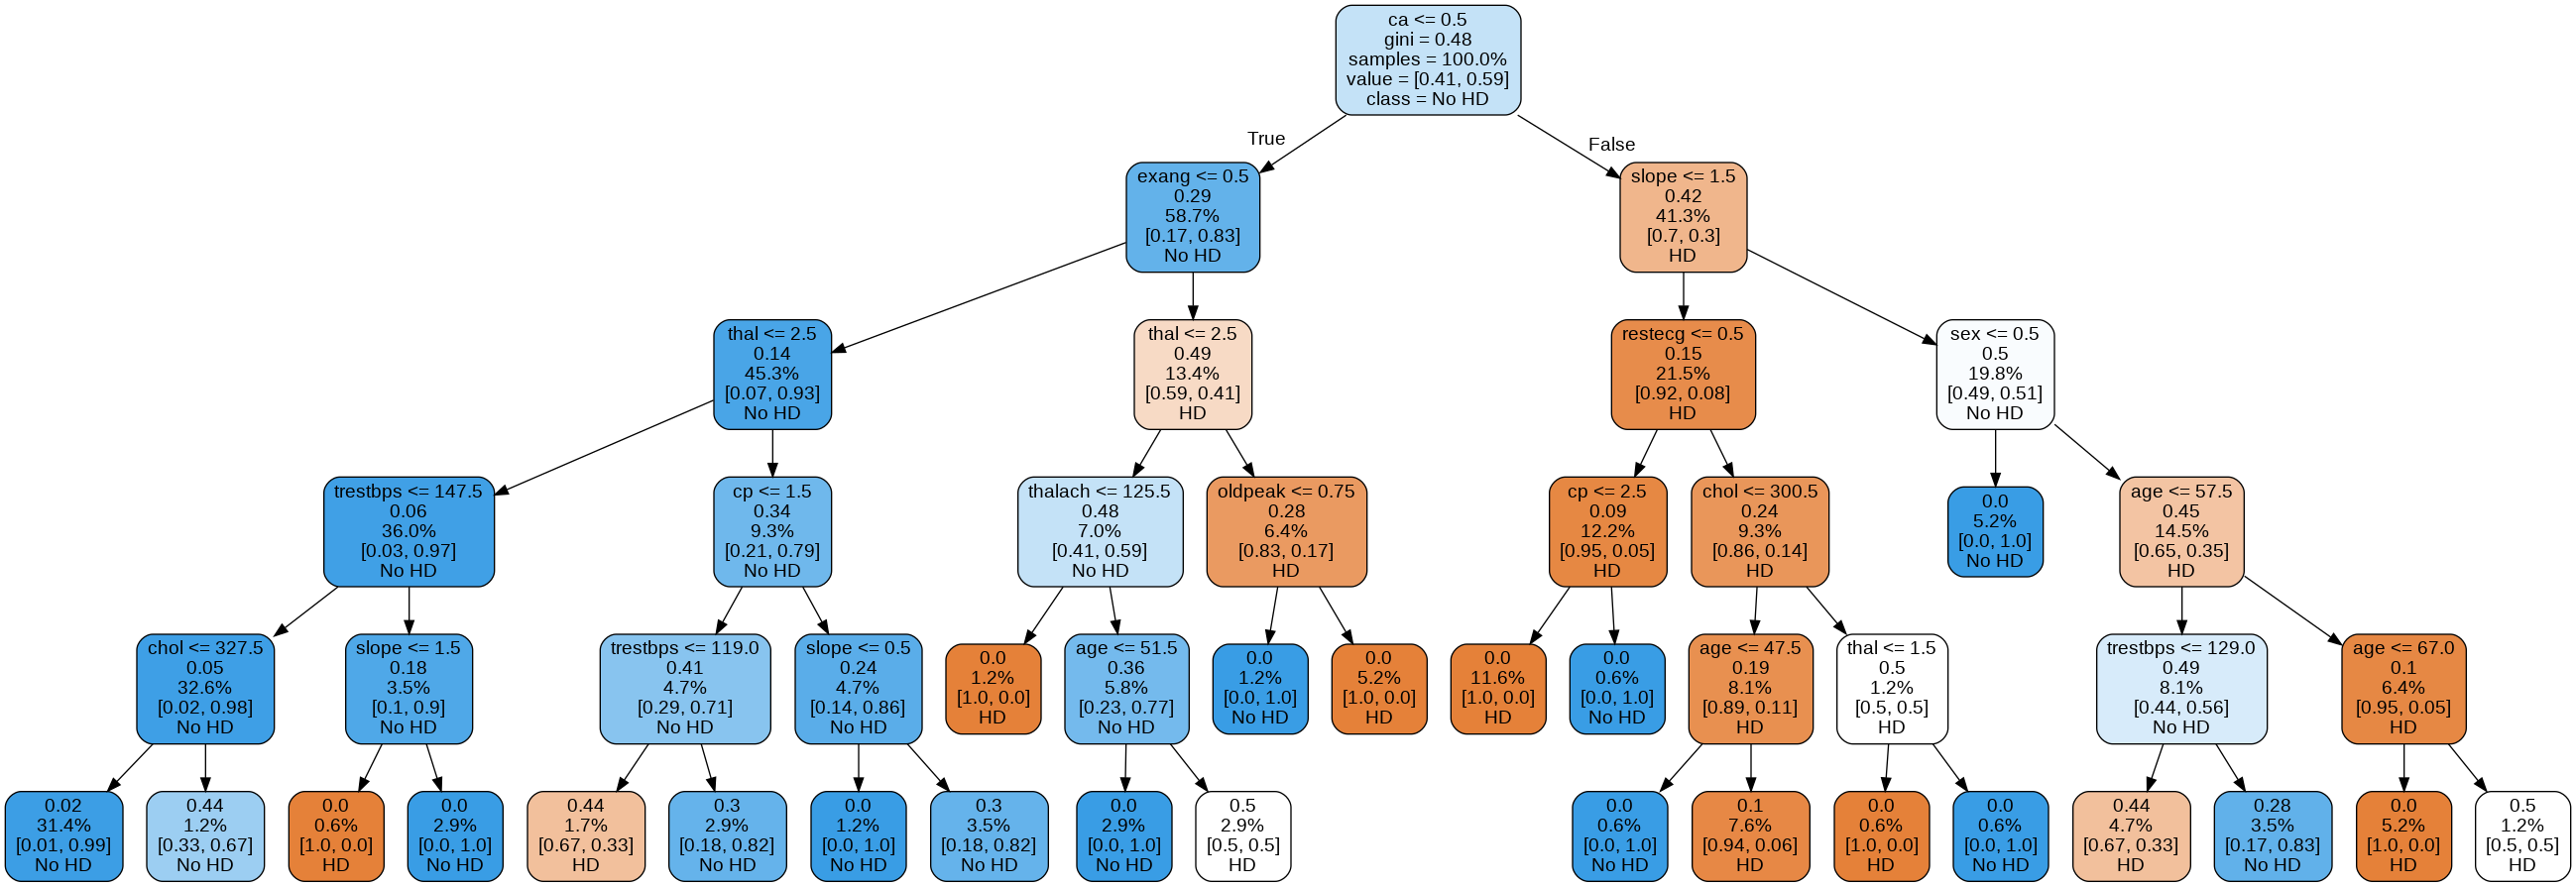

In [44]:
call(['dot', 
     '-Tpng',
     'tree.dot',
     '-o',
     'tree.png',
     '-Gdpi = 600'])

Image(filename = 'tree.png')

Inference on test set

In [54]:
# labels
y_predict = model.predict(x_test)

# probabilities
y_predict_prob = model.predict_proba(x_test)[:,1]


Confusion matrix

In [57]:
conf_matrix = confusion_matrix(y_test, y_predict)
conf_matrix

array([[15,  3],
       [ 1, 12]])

Sensitivity and specificity

In [60]:
total = sum(sum(conf_matrix))
sensitivity = conf_matrix[0,0]/[conf_matrix[0,0] + conf_matrix[1,0]]
print(sensitivity)

specificity = conf_matrix[1,1]/[conf_matrix[1,1] + conf_matrix[0,1]]
print(specificity)

[0.9375]
[0.8]


ROC curve

In [61]:
fpr, tpr, threshold = roc_curve(y_test, y_predict)

AUC

In [67]:
auc(fpr, tpr) 

0.8782051282051282

Permutation-based explaination - SHAP

In [73]:
# retrain estimator, removing at feature at a time
perm = PermutationImportance(model, random_state = 1).fit(x_test, y_test)

In [78]:
eli5.show_weights(perm, feature_names = cols)

Weight,Feature
0.0323 ± 0.0408,slope
0.0258 ± 0.0258,sex
0.0194 ± 0.0316,thal
0.0194 ± 0.0316,exang
0.0065 ± 0.0258,thalach
0.0065 ± 0.0632,cp
0 ± 0.0000,restecg
0 ± 0.0000,fbs
0 ± 0.0000,chol
0 ± 0.0000,age


Partial dependency plot

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa11ab3a910>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa11afd5d50>})

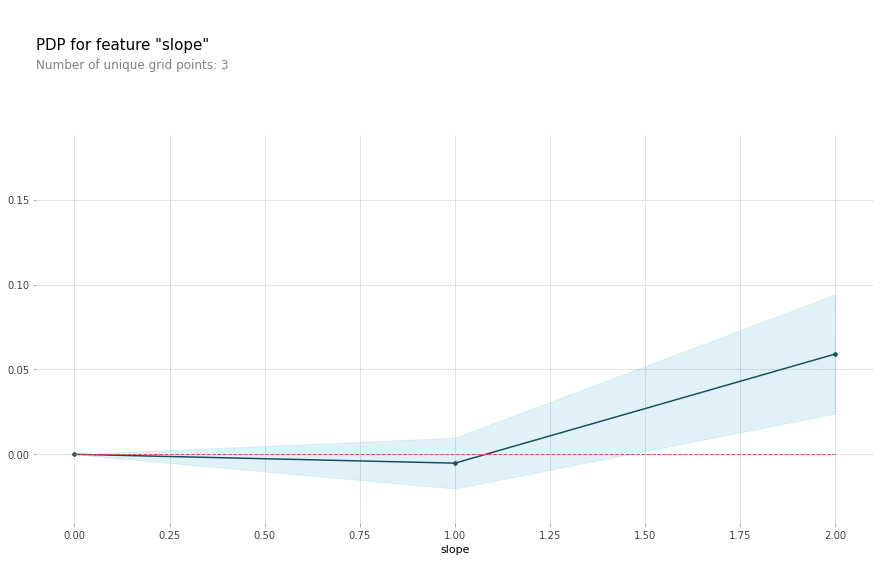

In [89]:
feat = 'slope'
pdp_d = pdp.pdp_isolate(model = model, 
                      dataset = x_test, 
                      model_features = cols, 
                      feature = feat)

pdp.pdp_plot(pdp_d, feat)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa11b0ca810>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa11c3b0750>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


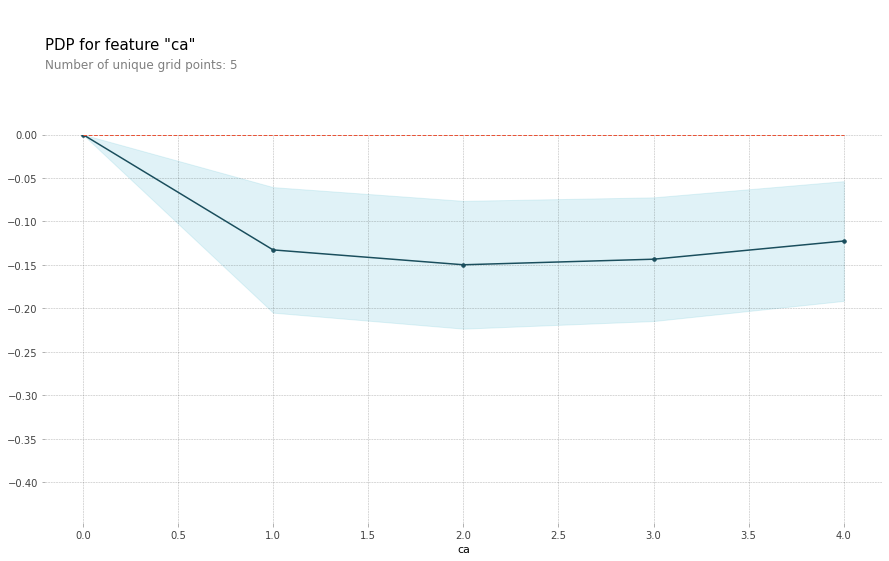

In [88]:
feat = 'ca'
pdp_d = pdp.pdp_isolate(model = model, 
                      dataset = x_test, 
                      model_features = cols, 
                      feature = feat)

pdp.pdp_plot(pdp_d, feat)

SHAP explainer

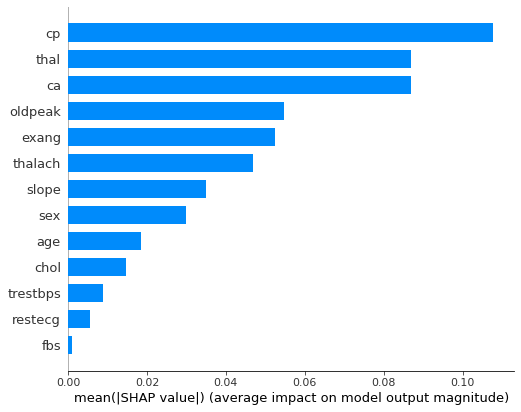

In [91]:
explainer =  shap.TreeExplainer(model)

shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values[1], x_test, plot_type = 'bar')

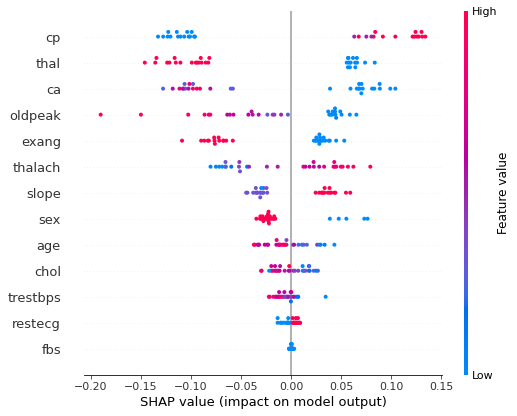

In [92]:
shap.summary_plot(shap_values[1], x_test)

How different variables affect different patients

In [96]:
def hd_risk_factors(model, patient):
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(patient)
  shap.initjs()
  return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [101]:
p  = x_test.iloc[1,:].astype(float)

In [102]:
hd_risk_factors(model, p)

In [103]:
p2  = x_test.iloc[2,:].astype(float)

In [104]:
hd_risk_factors(model, p2)

In [110]:
shap.initjs()
shap_values = explainer.shap_values(x_train.iloc[:10])
shap.force_plot(explainer.expected_value[1], shap_values[1], x_test[:10])